# Sandbox notebook: 
    
This notebook is for testing functions in peices while also viewing their output, plotting etc., (the things you're not really supposed to have in tests)

First order of business: Try to get the model creation to accept multiple inputs.

In [14]:
# Package dependencies and data visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns

# Inference package componenets
from bayboone.data_io import Data, OscProbability
from bayboone.inference import module as ifunc

#Allows reimporting the package without restarting the kernel
import importlib

The inputs for our new function are:
   - num_neutrinos: array of floats
        - The number of muon neutrinos shot at the detector in each energy bin
   - num_nue: array of floats
        - The number of electron neutrinos detected in each energy bin
   - energy_bins: array of floats
       - bins edges for the energies we've biined data into
   - est_ss2t: float between 0 and 1
       - estimated ss2t from previous experiments, for use in the prior
   - est_dms: float above 0
       - estimated dms from previous experiments, also for use in prior
       
       
We'll use 
   - num_neutrinos: 600000
   - num_nue: array of floats, calulated below
   - energy_bins: \[0.01, 0.3, 0.7, 1.5, 2\]
   - est_ss2t: 0.5
   - est_dms: 0.8

In [52]:
# Define all out inputs

UC = 1.27 #Unit conversion factor for the coefficient on dms in the oscillation probability

num_neutrinos = 600000
energy_bins = np.array([0, 2])#np.array([0.01, 0.3, 0.7, 1.5, 2]) #(To be used once everything is working properly.)

est_ss2t = 0.5
est_dms = 0.8

# Define L and E
# These shouldn't be exact, but for testing, we'll be lazy

E = np.zeros(energy_bins.size-1)
for i in range(E.size):
    E[i] = (energy_bins[i+1]-energy_bins[i])/2
L = 0.5 

num_nue = num_neutrinos*est_ss2t*(np.sin(est_dms*(UC*L)/E))**2
num_nue

array([70984.47190076])

# Begin to define what will eventually be the function that sets up our model

First, we look at taking the things we want to be inputs to the function, and making sure they are in the correct useable form

In [51]:
# make sure we can get values to use as mean energy from our bin edges when we use a truncated normal
energies = np.zeros(energy_bins.size-1)
sigmas = np.zeros(energy_bins.size-1)
for i in range(energies.size):
    energies[i] = energy_bins[i] + (energy_bins[i+1]-energy_bins[i])/2
    sigmas[i] = (energy_bins[i+1]-energy_bins[i]) # Most energy reconstructions aim for the standard deviation to be about the bin width. Later, we can upadate to make this a keyword argument
    
# When we attempt to use a uniform distribution for energy, these should be the edges      
energies_high = np.array(energy_bins[1:])
energies_low = np.array(energy_bins[:-1])


Now we set up the model

In [ ]:
osc_model = pm.Model()
with osc_model:
        
    # We don't know the exact production point of each neutrino, so we draw from a truncated gaussian (enforcing positive distance travelled)   
    L = pm.TruncatedNormal('L', mu = 0.500, sigma = 0.15, lower = 0, upper = 0.6) #units of km
    
    #If this works, we'll have one E distribution for each energy bin
    E = pm.TruncatedNormal('E', mu = energies , sigma = sigmas, lower = 0, upper = 10) #units of GeV
    #E = pm.Uniform('E', energies_low, energies_high)
        
    # Priors for unknown model parameters, centered on a prior estimate of ss2t, dms
    # Est_ss2t, est_dms defined in previous cell, will be input parameters in our function
    ss2t = pm.TruncatedNormal('sin^2_2theta', mu = est_ss2t, sigma = 0.1, lower = 0, upper = 1 ) #pm.Uniform('sin^2_2theta', 0.0001, 1)
    dms = pm.TruncatedNormal('delta_m^2', mu = est_dms, sigma = 0.1, lower = 0, upper = E*np.pi/(1.27*L))
    #"upper" limits the inferred point to only the first of the delta m^2 values that would fit the function, eliminating periodicity.
        
    # In the large n limit, because the number of oscillations is low, we use a Poisson approximation
    rate = pm.Deterministic('rate', num_neutrinos*ss2t*(np.sin(dms*(1.27*L)/E))**2)
        
    #Likelihood of observations
    measurements = pm.Poisson('nue_flux', mu = rate, observed = num_nue)

In [48]:
importlib.reload(ifunc)
ifunc.binned_oscillation_model(num_neutrinos, num_nue, energy_bins, est_ss2t, est_dms)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
/home/jybook/anaconda3/envs/phys201b/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 73 seconds.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
There were 562 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6925576349575393, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


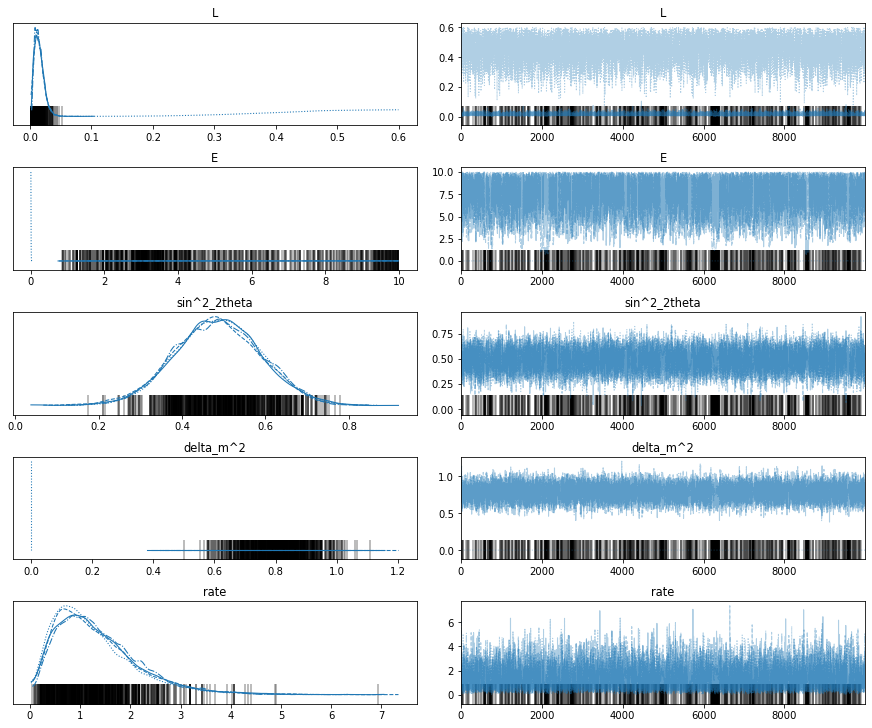

In [49]:
importlib.reload(ifunc)
trace = ifunc.binned_fit_model(num_neutrinos, num_nue, energy_bins)

In [34]:
df_trace = pm.trace_to_dataframe(trace)
joint_kde = sns.jointplot(x='delta_m^2', y='sin^2_2theta', data=df_trace, kind='scatter', s=0.2)

In [36]:
ifunc.print_fit_vals(trace)

delta_m^2 = 0.78 + 0.10 - 0.10
sin^2_2theta = 0.5 + 0.1 - 0.1


True